In [8]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
from pathlib import Path
import datetime as dt

plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [36]:
# add predicted prices in dataframe format to run through efficient frontier functions
# name dataframe df_closing
csvpath = Path("Resources/forecast_prices.csv")
df_closing = pd.read_csv(csvpath)
df_closing = df_closing.drop(columns=['Unnamed: 0'])
df_closing["Date"] = pd.to_datetime(df_closing["Date"]).dt.date
df_closing = df_closing.set_index("Date")
df_closing

,LQD_close_price,PZA_close_price,USO_close_price,TLT_close_price,QQQ_close_price,VMBS_close_price
Date,,,,,,
2021-01-13,136.520000,27.090000,35.760000,152.360000,316.000000,54.010000
2021-01-14,138.843613,27.096207,34.851509,153.237732,318.907410,53.924221
2021-01-15,140.689575,27.091772,34.909908,154.233353,322.679688,53.834557
2021-01-16,141.756500,27.087528,34.365986,155.183762,325.903687,53.757324
2021-01-17,142.126923,27.084291,34.418289,156.133698,328.474182,53.691902
2021-01-18,142.364563,27.080667,33.969398,157.123444,330.332947,53.635895
2021-01-19,142.650024,27.076170,34.037357,158.131607,331.862823,53.587311
2021-01-20,142.916260,27.071344,33.688328,159.110199,333.429108,53.544399
2021-01-21,143.134567,27.066589,33.731518,160.025528,335.130524,53.506279


In [45]:
# counter to automatically determine number of columns (securities) in dataframe
# will feed into efficient frontier functions
# rename column headers to sector names
df_closing.columns = ["Corporates","Municipals","Commodities","Treasuries","Equities","MBS"]
securities = 0
for col in df_closing.columns:
    securities += 1
securities

6

In [46]:
# calculate optimal distribution of etf using efficient frontier and scipy's optimize function
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
returns = df_closing.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0

In [47]:
# functions to calculate efficient frontier analysis
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((securities,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(securities)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [48]:
# display function
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=df_closing.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=df_closing.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation \n")
    print("Annualized Return:", round(rp,2))
    print("Annualized Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("\n")
    # print("Minimum Volatility Portfolio Allocation\n")
    # print("Annualized Return:", round(rp_min,2))
    # print("Annualized Volatility:", round(sdp_min,2))
    # print("\n")
    # print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Optimal Insurance Company Portfolio based on Efficient Frontier')
    plt.xlabel('annualized volatility')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation 

Annualized Return: 1.25
Annualized Volatility: 0.03


            Corporates  Municipals  Commodities  Treasuries  Equities  MBS
allocation         0.0         0.0         0.74         0.0     99.26  0.0
--------------------------------------------------------------------------------




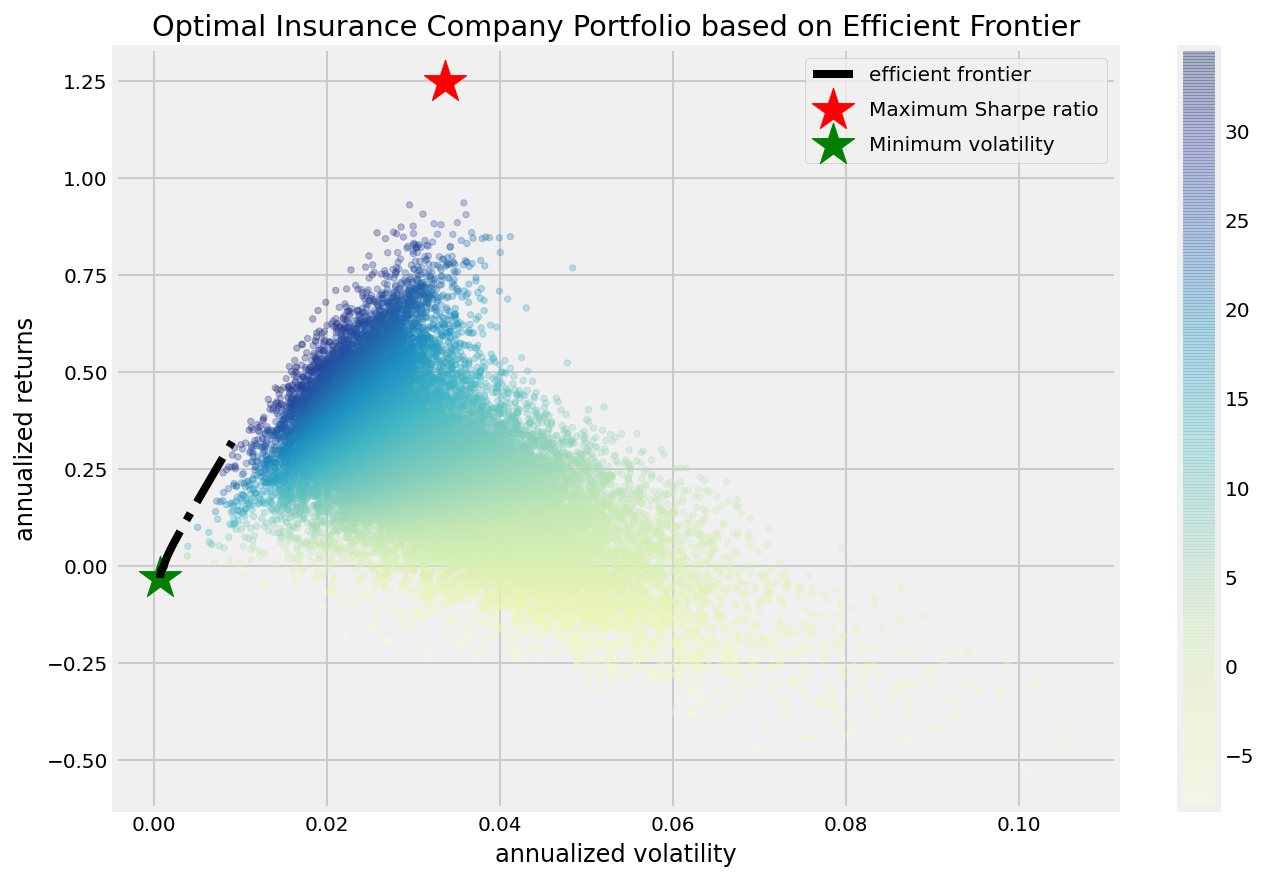

In [49]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)